In [ ]:
!pip install synthcity 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.8/345.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.9/298.9 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━

In [ ]:
!pip install sdv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.1/114.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 645.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.0
    Uninstalling packaging-23.0:
      Successfully uninstalled packaging-23.0


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from synthcity.plugins import Plugins
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer
from sklearn.model_selection import train_test_split

FEATURE_COLUMNS = [
    'Type',
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]', 
    'Torque [Nm]',
    'Tool wear [min]'
]

LABEL_A = "Target"
LABEL_B = "Failure Type"

FEATURES_AND_LABEL = [
    'Type',
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]', 
    'Torque [Nm]',
    'Tool wear [min]',
    'Target'

]

K_FOLDS = 5
TEST_SPLIT_SIZE = 0.25

PERCENTAGE_ADDED_SYNTHETIC_DATA = 0.5 # 1 = +100% positive samples

GENERATE_KWARGS = dict(
    uniformization_ratio=0,
    stretch_factor=1
)

SEEDS = (10,)

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)



# def get_synthia_independence_copula(X_train, y_train):
#     generator = syn.CopulaDataGenerator(verbose=False)
#     mask = (y_train == 1).ravel() # mask for positive samples
#     generator.fit(np.hstack((X_train[mask], y_train[mask].reshape(-1, 1))), copula=syn.IndependenceCopula())
#     return generator,mask

# def get_synthia_gaussian_copula(X_train, y_train):
#     generator = syn.CopulaDataGenerator(verbose=False)
#     mask = (y_train == 1).ravel() # mask for positive samples
#     parameterizer = syn.QuantileParameterizer(n_quantiles=100)
        
#     generator.fit(np.hstack((X_train[mask], y_train[mask].reshape(-1, 1))), copula=syn.GaussianCopula(), parameterize_by=parameterizer)
#     return generator,mask

In [39]:
df = (
    pd.read_csv("/content/predictive_maintenance.csv", )
    .assign(
        Type=lambda x: LabelEncoder().fit_transform(x["Type"])
    )
)
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,1,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,1,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,1,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,1,298.2,308.7,1408,40.0,9,0,No Failure


# Copula with SDV

In [40]:
df = df.loc[:, FEATURES_AND_LABEL]
df.head()


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,2,298.1,308.6,1551,42.8,0,0
1,1,298.2,308.7,1408,46.3,3,0
2,1,298.1,308.5,1498,49.4,5,0
3,1,298.2,308.6,1433,39.5,7,0
4,1,298.2,308.7,1408,40.0,9,0


## Gaussian Copula


In [41]:

#chosing data to fit
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, FEATURE_COLUMNS], df.loc[:, LABEL_A],
    test_size=0.25, random_state=20
)
train_indexes = X_train.index

df_gen_positives = df.loc[train_indexes, :]
df_gen_positives = df_gen_positives[df[LABEL_A] == 1]
#fitting the synthesizer
#Creating GaussianCopulaSynthesizer object
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_gen_positives)
Gaussian = GaussianCopulaSynthesizer(metadata, default_distribution='norm')
Gaussian.fit(df_gen_positives)
generated_data = Gaussian.sample(num_rows = len(df_gen_positives))

#training RandomForest
X_train_syn = np.vstack((X_train, generated_data.loc[:, FEATURE_COLUMNS]))
y_train_syn = np.hstack((y_train, generated_data.loc[:, LABEL_A]))
clf_syn = RandomForestClassifier(random_state=20)
clf_syn = clf_syn.fit(X_train_syn, y_train_syn)
# Evaluate classifier on balanced data
y_pred_syn = clf_syn.predict(X_test)
clf_report_syn = classification_report(y_test, y_pred_syn)
clf_conf_matrix_syn = confusion_matrix(y_test, y_pred_syn)
one_metrics_syn = precision_recall_fscore_support(y_test, y_pred_syn, average="binary")


In [42]:
print(one_metrics_syn)

(0.875, 0.5975609756097561, 0.7101449275362318, None)


## CTGAN

In [43]:

#chosing data to fit
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, FEATURE_COLUMNS], df.loc[:, LABEL_A],
    test_size=0.25, random_state=20
)
train_indexes = X_train.index

df_gen_positives = df.loc[train_indexes, :]
df_gen_positives = df_gen_positives[df[LABEL_A] == 1]

#Creating CTGANSynthesizer object
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_gen_positives)
CTGAN = CTGANSynthesizer(metadata)
#fitting the synthesizer
CTGAN.fit(df_gen_positives)
generated_data = CTGAN.sample(num_rows = len(df_gen_positives))

#training RandomForest
X_train_syn = np.vstack((X_train, generated_data.loc[:, FEATURE_COLUMNS]))
y_train_syn = np.hstack((y_train, generated_data.loc[:, LABEL_A]))
clf_syn = RandomForestClassifier(random_state=20)
clf_syn = clf_syn.fit(X_train_syn, y_train_syn)
# Evaluate classifier on balanced data
y_pred_syn = clf_syn.predict(X_test)
clf_report_syn = classification_report(y_test, y_pred_syn)
clf_conf_matrix_syn = confusion_matrix(y_test, y_pred_syn)
one_metrics_syn = precision_recall_fscore_support(y_test, y_pred_syn, average="binary")
print(one_metrics_syn)

(0.9245283018867925, 0.5975609756097561, 0.7259259259259259, None)


# Kfold with Gaussian Copule

In [44]:
SEEDS = [42, 30, 2, 1500]

In [45]:
results = []

for seed in SEEDS:
    set_seed(seed)
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=seed)
    
    for train_index, test_index in skf.split(df.loc[:, FEATURE_COLUMNS], 
                                             df.loc[:, LABEL_A]):

        

        df_gen = df.loc[train_index]
        df_gen_positives = df_gen[df_gen[LABEL_A] == 1]
        metadata = SingleTableMetadata()
        metadata.detect_from_dataframe(data=df_gen_positives)
        Gaussian = GaussianCopulaSynthesizer(metadata, default_distribution='norm')
        Gaussian.fit(df_gen_positives)
        generated_data = Gaussian.sample(num_rows = len(df_gen_positives))
        


        X_train, X_test = df.loc[train_index, FEATURE_COLUMNS], df.loc[test_index, FEATURE_COLUMNS]
        y_train, y_test = df.loc[train_index, LABEL_A], df.loc[test_index, LABEL_A]

    # Fit classifier on imbalanced data
        clf = RandomForestClassifier(random_state=seed)
        clf = clf.fit(X_train, y_train)
    # Evaluate classifier on imbalanced data
        y_pred = clf.predict(X_test)
        clf_report = classification_report(y_test, y_pred)
        clf_conf_matrix = confusion_matrix(y_test, y_pred)
        one_metrics_normal = precision_recall_fscore_support(y_test, y_pred, average="binary")
        results.append(["normal"] + list(one_metrics_normal) + [seed])

    # Fit classifier on balanced data
        X_train_syn = np.vstack((X_train, generated_data.loc[:, FEATURE_COLUMNS]))
        y_train_syn = np.hstack((y_train, generated_data.loc[:, LABEL_A]))
        clf_syn = RandomForestClassifier(random_state=seed)
        clf_syn = clf_syn.fit(X_train_syn, y_train_syn)
    # Evaluate classifier on balanced data
        y_pred_syn = clf_syn.predict(X_test)
        clf_report_syn = classification_report(y_test, y_pred_syn)
        clf_conf_matrix_syn = confusion_matrix(y_test, y_pred_syn)
        one_metrics_syn = precision_recall_fscore_support(y_test, y_pred_syn, average="binary")
        results.append(["synthetic"] + list(one_metrics_syn)+ [seed])

df_results_synthia_ind_g = pd.DataFrame(results, columns=["dataset_type","precision", "recall", "f1-score", "support", "seed"]).drop(columns=["support"])

In [46]:
df_results_synthia_ind_g.groupby(["dataset_type", "seed"]).mean().reset_index().groupby(["dataset_type", "seed"]).mean()

precision    recall  f1-score
dataset_type seed                               
normal       2      0.895433  0.584197  0.705248
             30     0.880226  0.619535  0.725086
             42     0.877407  0.578183  0.694386
             1500   0.891463  0.610536  0.723764
synthetic    2      0.811673  0.628314  0.706649
             30     0.827624  0.646137  0.723641
             42     0.832933  0.634109  0.719065
             1500   0.821500  0.660799  0.731913

In [47]:
from sklearn.inspection import permutation_importance
o_r = permutation_importance(clf, X_train, y_train, n_repeats=30, random_state=1500)
ag_r = permutation_importance(clf, X_train_syn, y_train_syn, n_repeats=30, random_state=1500)


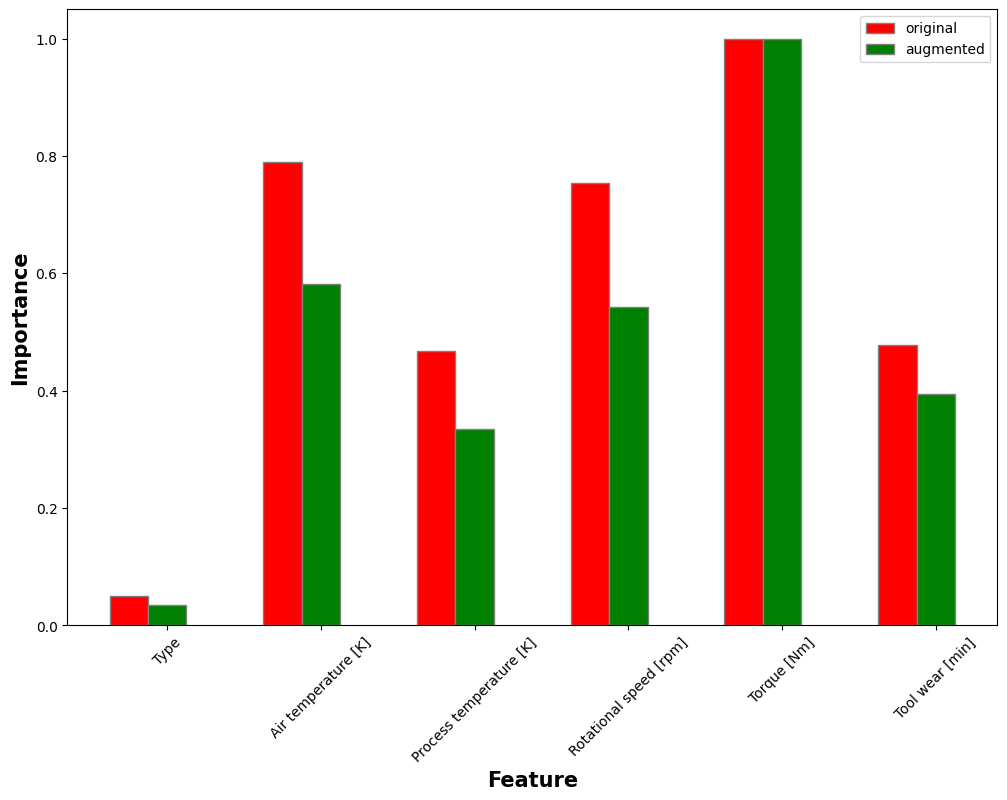

In [48]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
IT = (o_r.importances_mean/ np.max(o_r.importances_mean)).tolist()
ECE = (ag_r.importances_mean/ np.max(ag_r.importances_mean)).tolist()

 
# Set position of bar on X axis
br1 = np.arange(len(IT))
br2 = [x + barWidth for x in br1]

 
# Make the plot
plt.bar(br1, IT, color ='r', width = barWidth,
        edgecolor ='grey', label ='original')
plt.bar(br2, ECE, color ='g', width = barWidth,
        edgecolor ='grey', label ='augmented')

 
# Adding Xticks
plt.xlabel('Feature', fontweight ='bold', fontsize = 15)
plt.ylabel('Importance', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(IT))],
        [i for i in df_gen.columns[:-1]], rotation = 45)
 
plt.legend()
plt.show()

# Kfold with CTGANs

In [49]:
results = []

for seed in SEEDS:
    set_seed(seed)
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=seed)
    
    for train_index, test_index in skf.split(df.loc[:, FEATURE_COLUMNS], 
                                             df.loc[:, LABEL_A]):

        

        df_gen = df.loc[train_index]
        df_gen_positives = df_gen[df_gen[LABEL_A] == 1]
        metadata = SingleTableMetadata()
        metadata.detect_from_dataframe(data=df_gen_positives)
        CTGAN = CTGANSynthesizer(metadata)
        CTGAN.fit(df_gen_positives)
        generated_data = CTGAN.sample(num_rows = len(df_gen_positives))
        


        X_train, X_test = df.loc[train_index, FEATURE_COLUMNS], df.loc[test_index, FEATURE_COLUMNS]
        y_train, y_test = df.loc[train_index, LABEL_A], df.loc[test_index, LABEL_A]

    # Fit classifier on imbalanced data
        clf = RandomForestClassifier(random_state=seed)
        clf = clf.fit(X_train, y_train)
    # Evaluate classifier on imbalanced data
        y_pred = clf.predict(X_test)
        clf_report = classification_report(y_test, y_pred)
        clf_conf_matrix = confusion_matrix(y_test, y_pred)
        one_metrics_normal = precision_recall_fscore_support(y_test, y_pred, average="binary")
        results.append(["normal"] + list(one_metrics_normal) + [seed])

    # Fit classifier on balanced data
        X_train_syn = np.vstack((X_train, generated_data.loc[:, FEATURE_COLUMNS]))
        y_train_syn = np.hstack((y_train, generated_data.loc[:, LABEL_A]))
        clf_syn = RandomForestClassifier(random_state=seed)
        clf_syn = clf_syn.fit(X_train_syn, y_train_syn)
    # Evaluate classifier on balanced data
        y_pred_syn = clf_syn.predict(X_test)
        clf_report_syn = classification_report(y_test, y_pred_syn)
        clf_conf_matrix_syn = confusion_matrix(y_test, y_pred_syn)
        one_metrics_syn = precision_recall_fscore_support(y_test, y_pred_syn, average="binary")
        results.append(["synthetic"] + list(one_metrics_syn)+ [seed])

df_results_synthia_ind = pd.DataFrame(results, columns=["dataset_type","precision", "recall", "f1-score", "support", "seed"]).drop(columns=["support"])

In [50]:
df_results_synthia_ind.groupby(["dataset_type", "seed"]).mean().reset_index().groupby(["dataset_type", "seed"]).mean()

precision    recall  f1-score
dataset_type seed                               
normal       2      0.895433  0.584197  0.705248
             30     0.880226  0.619535  0.725086
             42     0.877407  0.578183  0.694386
             1500   0.891463  0.610536  0.723764
synthetic    2      0.840894  0.654785  0.735034
             30     0.825159  0.663521  0.731025
             42     0.834403  0.654741  0.730617
             1500   0.828073  0.654960  0.730792

In [51]:
from sklearn.inspection import permutation_importance
o_r = permutation_importance(clf, X_train, y_train, n_repeats=30, random_state=1500)
ag_r = permutation_importance(clf, X_train_syn, y_train_syn, n_repeats=30, random_state=1500)

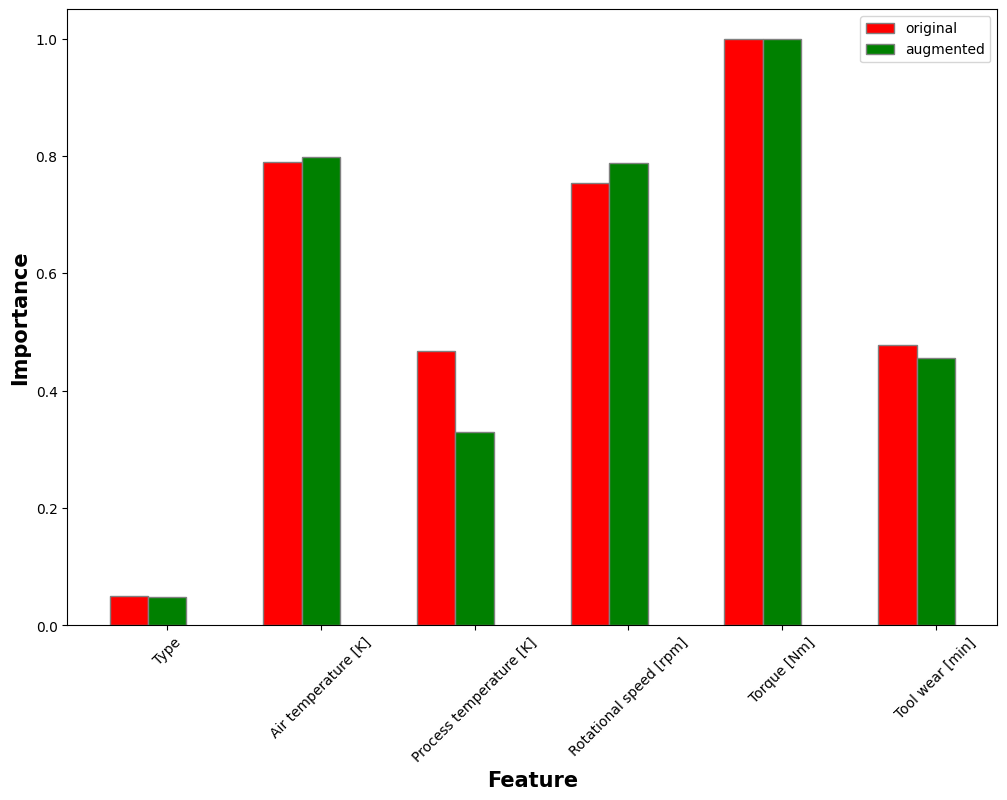

In [52]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
IT = (o_r.importances_mean/ np.max(o_r.importances_mean)).tolist()
ECE = (ag_r.importances_mean/ np.max(ag_r.importances_mean)).tolist()

 
# Set position of bar on X axis
br1 = np.arange(len(IT))
br2 = [x + barWidth for x in br1]

 
# Make the plot
plt.bar(br1, IT, color ='r', width = barWidth,
        edgecolor ='grey', label ='original')
plt.bar(br2, ECE, color ='g', width = barWidth,
        edgecolor ='grey', label ='augmented')

 
# Adding Xticks
plt.xlabel('Feature', fontweight ='bold', fontsize = 15)
plt.ylabel('Importance', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(IT))],
        [i for i in df_gen.columns[:-1]], rotation = 45)
 
plt.legend()
plt.show()